In [1]:
import copy
from collections import defaultdict

import gymnasium
from gymnasium.envs.toy_text.cliffwalking import (
    UP, RIGHT, DOWN, LEFT, POSITION_MAPPING
)
import numpy as np
import tqdm
from IPython import display
from PIL import Image, ImageEnhance
import moviepy.editor as mpy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


In [2]:
class CliffWalkingEnv(gymnasium.Wrapper):
    def __init__(self, random_init_state=False, max_episode_steps=1000, 
                 render_mode="rgb_array", **kwargs):
        env = gymnasium.make(
            "CliffWalking-v1",
            max_episode_steps=max_episode_steps,
            render_mode=render_mode,
            **kwargs
        )
        super().__init__(env)

        self.nS = self.env.get_wrapper_attr('nS')
        self.nA = self.env.get_wrapper_attr('nA')
        self.shape = self.env.get_wrapper_attr('shape')

        # The original transition probabilities for absorbing states are not correct.
        P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(self.nA)}
            P[s][UP] = self._calculate_transition_prob(position, UP)
            P[s][RIGHT] = self._calculate_transition_prob(position, RIGHT)
            P[s][DOWN] = self._calculate_transition_prob(position, DOWN)
            P[s][LEFT] = self._calculate_transition_prob(position, LEFT)
        self.env.set_wrapper_attr('P', P)

        if random_init_state:
            initial_state_distrib = np.ones(self.nS)
            cliff_positions = np.asarray(np.where(env.get_wrapper_attr('_cliff')))
            cliff_states = np.ravel_multi_index(cliff_positions, self.shape)
            initial_state_distrib[cliff_states] = 0.0
            initial_state_distrib[47] = 0.0
            initial_state_distrib /= np.sum(initial_state_distrib, keepdims=True)
            self.env.set_wrapper_attr('initial_state_distrib', initial_state_distrib)

        # Calculate transition probabilities and rewards
        rewards = np.full((self.nS, self.nA, self.nS), np.nan)
        transition_probs = np.zeros((self.nS, self.nA, self.nS))
        masks = np.zeros((self.nS, self.nA, self.nS))
        for state in range(self.nS):
            for action in range(self.nA):
                _, next_state, reward, terminated = self.env.get_wrapper_attr('P')[state][action][0]
                rewards[state, action, next_state] = reward
                transition_probs[state, action, next_state] += 1.0
                masks[state, action, next_state] = float(not terminated)
        transition_probs /= np.sum(transition_probs, axis=-1, keepdims=True)
        assert np.all(np.sum(transition_probs, axis=-1) == 1.0)
        reward_max, reward_min = np.nanmax(rewards), np.nanmin(rewards)
        rewards[np.isnan(rewards)] = reward_min
        assert np.all((reward_min <= rewards) & (rewards <= reward_max))

        self._orig_reward_min, self._orig_reward_max = reward_min, reward_max
        self.orig_rewards = rewards
        self.rewards = (rewards - reward_min) / (reward_max - reward_min)
        self.transition_probs = transition_probs
        self.masks = masks

    def _calculate_transition_prob(self, current, move):
        """Determine the outcome for an action. Transition Prob is always 1.0.
        
        The original transition probabilities for absorbing states are not correct.
        """
        if not self.env.get_wrapper_attr('is_slippery'):
            deltas = [POSITION_MAPPING[move]]
        else:
            deltas = [
                POSITION_MAPPING[act] for act in [(move - 1) % 4, move, (move + 1) % 4]
            ]
        outcomes = []

        # the single absorbing state is the goal
        goal_position = np.asarray([self.shape[0] - 1, self.shape[1] - 1])
        goal_state = np.ravel_multi_index(goal_position, self.shape)
        current_position = np.array(current)
        current_state = np.ravel_multi_index(tuple(current_position), self.shape)
        for delta in deltas:
            if current_state == goal_state:
                new_state = current_state
                reward = 0
                is_terminated = True
            else:
                new_position = current_position + np.array(delta)
                new_position = self.env.get_wrapper_attr('_limit_coordinates')(new_position).astype(int)
                new_state = np.ravel_multi_index(tuple(new_position), self.shape)
                if self.env.get_wrapper_attr('_cliff')[tuple(new_position)]:
                    reward = -100
                    new_state = self.env.get_wrapper_attr('start_state_index')
                else:
                    reward = -1
                is_terminated = (new_state == goal_state)
            outcomes.append((1 / len(deltas), new_state, reward, is_terminated))
        return outcomes

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.env.set_wrapper_attr('start_state_index', obs)

        return obs, info

    def step(self, action):
        obs, orig_reward, terminated, truncated, info = super().step(action)
        reward = (orig_reward - self._orig_reward_min) / (self._orig_reward_max - self._orig_reward_min)

        return obs, reward, terminated, truncated, info

In [3]:
# collect dataset
discount = 0.95
max_episode_steps = 100
env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

# uniform behavioral policy
behavioral_policy = np.ones([env.nS, env.nA]) / env.nA

dataset = defaultdict(list)

# dataset size = 100K
num_episodes = 1000
max_episode_steps = 100
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    obs, info = env.reset()
    for step in range(max_episode_steps):
        action = np.random.choice(np.arange(env.nA), p=behavioral_policy[obs])
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['rewards'].append(reward)
        dataset['next_observations'].append(next_obs)
        dataset['masks'].append(not terminated)
        dataset['terminals'].append(truncated)
        
        num_transitions += 1
        
        obs = next_obs

for k, v in dataset.items():
    if k in ['observations', 'actions', 'next_observations']:
        dtype = np.int32
    elif k == 'terminals':
        dtype = bool
    else:
        dtype = np.float32
    dataset[k] = np.array(v, dtype=dtype)

print("num of total transitions {}".format(num_transitions))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 330.70it/s]

num of total transitions 100000


In [4]:
# value iteration to find the optimal Q
rewards = env.rewards
transition_probs = env.transition_probs

opt_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_q = np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.nS, env.nA])
opt_policy[np.arange(env.nS), np.argmax(opt_q, axis=-1)] = 1.0

# value iteration to find the behavioral Q
behavioral_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  behavioral_q = np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.sum(behavioral_policy * behavioral_q, axis=-1))
behavioral_v = np.sum(behavioral_policy * behavioral_q, axis=-1)

In [5]:
print("optimal q and optimal policy: ")
print(opt_q)
print(opt_policy)

print("behavioral q: ")
print(behavioral_q)

optimal q and optimal policy: 
[[19.89265825 19.897535   19.897535   19.89265825]
 [19.897535   19.90266842 19.90266842 19.89265825]
 [19.90266842 19.90807202 19.90807202 19.897535  ]
 [19.90807202 19.91376002 19.91376002 19.90266842]
 [19.91376002 19.91974739 19.91974739 19.90807202]
 [19.91974739 19.92604988 19.92604988 19.91376002]
 [19.92604988 19.93268409 19.93268409 19.91974739]
 [19.93268409 19.93966746 19.93966746 19.92604988]
 [19.93966746 19.94701838 19.94701838 19.93268409]
 [19.94701838 19.95475619 19.95475619 19.93966746]
 [19.95475619 19.96290125 19.96290125 19.94701838]
 [19.96290125 19.96290125 19.971475   19.95475619]
 [19.89265825 19.90266842 19.90266842 19.897535  ]
 [19.897535   19.90807202 19.90807202 19.897535  ]
 [19.90266842 19.91376002 19.91376002 19.90266842]
 [19.90807202 19.91974739 19.91974739 19.90807202]
 [19.91376002 19.92604988 19.92604988 19.91376002]
 [19.91974739 19.93268409 19.93268409 19.91974739]
 [19.92604988 19.93966746 19.93966746 19.92604988]


In [6]:
def get_video(renders):
    """Return a Weights & Biases video.

    It takes a list of videos and reshapes them into a single video with the specified number of columns.

    Args:
        renders: List of videos. Each video should be a numpy array of shape (t, h, w, c).
        n_cols: Number of columns for the reshaped video. If None, it is set to the square root of the number of videos.
    """
    # Pad videos to the same length.
    max_length = max([len(render) for render in renders])
    for i, render in enumerate(renders):
        assert render.dtype == np.uint8

        # Decrease brightness of the padded frames.
        final_frame = render[-1]
        final_image = Image.fromarray(final_frame)
        enhancer = ImageEnhance.Brightness(final_image)
        final_image = enhancer.enhance(0.5)
        final_frame = np.array(final_image)

        pad = np.repeat(final_frame[np.newaxis, ...], max_length - len(render), axis=0)
        renders[i] = np.concatenate([render, pad], axis=0)

        # Add borders.
        renders[i] = np.pad(renders[i], ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    renders = np.array(renders)  # (n, t, h, w, c)

    return renders

In [7]:
# evaluation the optimal pi
max_episode_steps = 100
eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

num_episodes = 6
successes = []
renders = []
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, info = eval_env.reset()
    render = eval_env.render().copy()
    while not done:
        action = np.random.choice(np.arange(eval_env.nA), p=opt_policy[obs])
        next_obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        next_render = eval_env.render().copy()
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['rewards'].append(reward)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['renders'].append(render)
        
        obs = next_obs
        render = next_render
    traj_dataset['renders'].append(render)  # append the last frame
    
    successes.append(47 in traj_dataset['next_observations'])
    renders.append(np.asarray(traj_dataset['renders']))

sr = np.mean(successes)
print("success rate = {}".format(sr))

videos = get_video(renders)

fps = 15
num_rows = 2
num_cols = 3
clip_array = []
for row in range(num_rows):
    clip_row = []
    for col in range(num_cols):
        idx = row * num_cols + col
        
        clip = mpy.ImageSequenceClip(list(videos[idx]), fps=fps)
        clip_row.append(clip)
    clip_array.append(clip_row)

clip_array = mpy.clips_array(clip_array)
clip_array.ipython_display(fps=fps, loop=True, autoplay=True)

100%|██████████| 6/6 [00:00<00:00, 28.69it/s]


success rate = 1.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


#### Utils

In [8]:
def sample_batch(batch_size):
    dataset_size = len(dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], dataset)
    
    return batch

In [9]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

#### Q-learning

In [11]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.nS)
    action = jax.nn.one_hot(action, env.nA)
    inputs = jnp.concatenate([obs, action], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

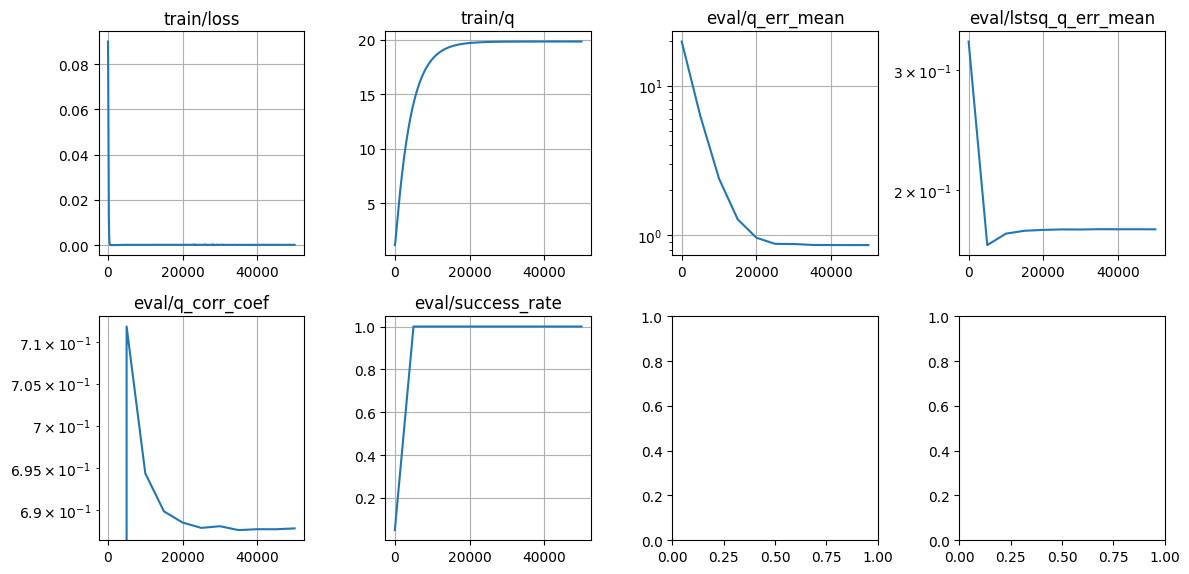

100%|██████████| 50000/50000 [01:05<00:00, 763.34it/s] 


In [12]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  # next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  # next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  # next_q = jnp.maximum(next_q1, next_q2)
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  next_qs = critic.apply(target_params, next_observations, next_actions)
  next_qs = next_qs.reshape([batch_size, env.nA])
  next_q = jnp.max(next_qs, axis=-1)
  target_q = batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=3e-4 * 512 * 2)
optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([env.nS, env.nA])
  # scaled_q = q * (opt_q / q).mean()
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q.reshape(-1),
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  # scaled_q_err_mean = jnp.mean(np.abs(scaled_q - opt_q))
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q.reshape(-1))[0, 1]
  
  # evaluate the policy
  a = jnp.argmax(q, axis=-1)
  policy = jax.nn.one_hot(a, env.nA)
  policy = np.asarray(policy)
  
  # evaluation
  num_eval_episodes = 100
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=policy[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)
  
  info = {
    'q_err_mean': q_err_mean,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'q_corr_coef': q_corr_coef,
    'success_rate': sr
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [13]:
q_learning_metrics = metrics
print(q_learning_metrics['eval/q_err_mean'][-1])
print(q_learning_metrics['eval/lstsq_q_err_mean'][-1])
print(q_learning_metrics['eval/q_corr_coef'][-1])
print(q_learning_metrics['eval/success_rate'][-1])

[5.00000000e+04 8.60324085e-01]
[5.00000000e+04 1.74886912e-01]
[5.00000000e+04 6.87905848e-01]
[5.e+04 1.e+00]


#### C51

In [10]:
class CategoricalCritic(nn.Module):
  atoms: jnp.ndarray
  
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.nS)
    action = jax.nn.one_hot(action, env.nA)
    inputs = jnp.concatenate([obs, action], axis=-1)

    num_atoms = len(self.atoms)

    logits = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(num_atoms),
    ])(inputs)
    
    logits = logits.reshape([obs.shape[0], num_atoms])
    probs = jax.nn.softmax(logits, axis=-1)
    qs = jnp.sum(probs * self.atoms[None], axis=-1)

    return qs, probs

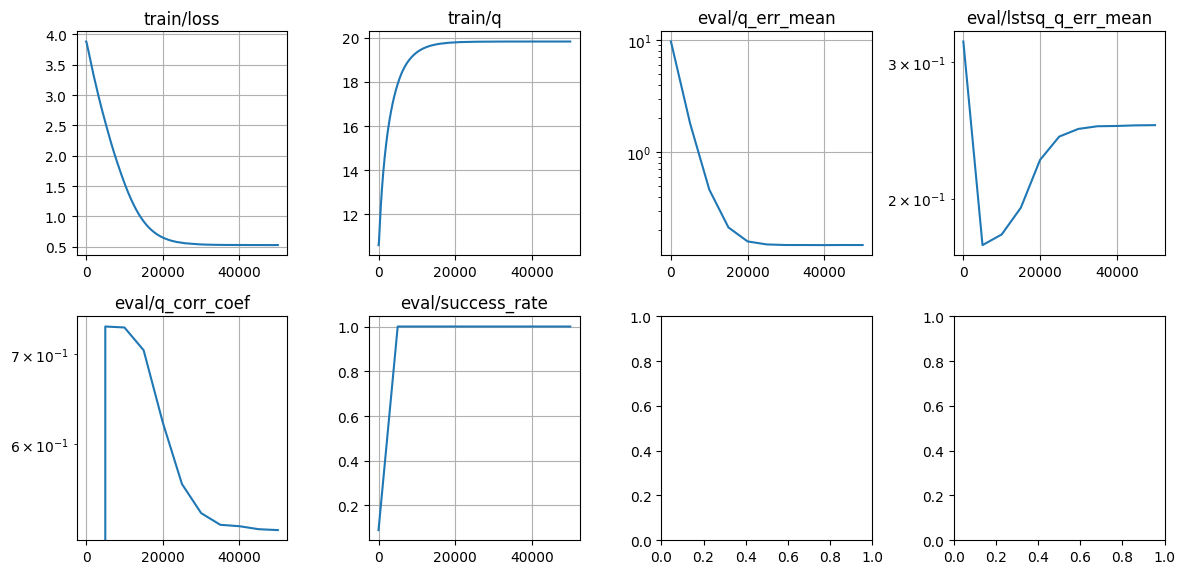

100%|██████████| 50000/50000 [01:12<00:00, 689.60it/s]


In [15]:
batch_size = 1024
tau = 0.005
num_atoms = 51
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards = env.rewards
v_min = rewards.min() / (1 - discount)
v_max = rewards.max() / (1 - discount)
atoms = jnp.linspace(v_min, v_max, num_atoms)
delta_atom = (v_max - v_min) / (num_atoms - 1)
offset = jnp.arange(batch_size, dtype=jnp.int32) * num_atoms
offset = offset[:, None]
offset = jnp.broadcast_to(offset, (batch_size, num_atoms))

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
cate_critic = CategoricalCritic(atoms)
cate_critic_params = cate_critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_cate_critic_params = copy.deepcopy(cate_critic_params)

def loss_fn(params, target_params, batch):
  q, probs = cate_critic.apply(params, batch['observations'], batch['actions'])

  # next_q1, next_probs1 = cate_critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  # next_q2, next_probs2 = cate_critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  # next_q = jnp.stack([next_q1, next_q2], axis=1)
  # next_probs = jnp.stack([next_probs1, next_probs2], axis=1)
  # next_actions = jnp.argmax(next_q, axis=1)
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  next_qs, next_probs = cate_critic.apply(target_params, next_observations, next_actions)
  next_probs = next_probs.reshape([batch_size, env.nA, num_atoms])
  next_qs = next_qs.reshape([batch_size, env.nA])
  next_actions = jnp.argmax(next_qs, axis=-1)
  next_probs = jnp.sum(next_probs * jax.nn.one_hot(next_actions, env.nA)[..., None], axis=1)

  projected_atoms = jnp.clip(batch['rewards'][:, None] + discount * atoms[None], v_min, v_max)
  projected_bins = (projected_atoms - v_min) / delta_atom
  lower_bins = jnp.floor(projected_bins).astype(jnp.int32)
  upper_bins = jnp.ceil(projected_bins).astype(jnp.int32)

  delta_mass_lower = (upper_bins + (lower_bins == upper_bins).astype(jnp.int32) - projected_bins) * next_probs
  delta_mass_upper = (projected_bins - lower_bins) * next_probs
  
  mass = jnp.zeros(batch_size * num_atoms)
  mass = mass.at[(lower_bins + offset).ravel()].add(delta_mass_lower.ravel())
  mass = mass.at[(upper_bins + offset).ravel()].add(delta_mass_upper.ravel())
  mass = mass.reshape(batch_size, num_atoms)

  loss = jnp.sum(-mass * jnp.log(probs + 1e-8), axis=-1).mean()
  
  # logging
  # q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.nA), axis=1)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=3e-4 * 512 * 2)
optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(cate_critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)
  q, _ = cate_critic.apply(params, obs, actions)
  q = q.reshape([env.nS, env.nA])
  # scaled_q = q * (opt_q / q).mean()
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q.reshape(-1),
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q.reshape(-1))[0, 1]
  
  # evaluate the policy
  a = jnp.argmax(q, axis=-1)
  policy = jax.nn.one_hot(a, env.nA)
  policy = np.asarray(policy)
  
  # evaluation
  num_eval_episodes = 100
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=policy[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)
  
  info = {
    'q_err_mean': q_err_mean,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'q_corr_coef': q_corr_coef,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  cate_critic_params, target_cate_critic_params, opt_state, loss, info = update_fn(
    cate_critic_params, target_cate_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(cate_critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [16]:
c51_metrics = metrics

print(c51_metrics['eval/q_err_mean'][-1])
print(c51_metrics['eval/lstsq_q_err_mean'][-1])
print(c51_metrics['eval/q_corr_coef'][-1])
print(c51_metrics['eval/success_rate'][-1])

[5.00000000e+04 1.47844613e-01]
[5.00000000e+04 2.48621866e-01]
[5.00000000e+04 5.18750668e-01]
[5.e+04 1.e+00]


### IQN

In [11]:
class CosineEmbedding(nn.Module):
  num_cosines: int = 64
  embedding_dim: int = 512
  
  @nn.compact
  def __call__(self, taus):
    batch_size, num_taus = taus.shape[0:2]

    freqs = jnp.pi * jnp.arange(1, self.num_cosines + 1)[None, None]
    cos_embeddings = jnp.cos(freqs * taus[..., None]).reshape(
        batch_size * num_taus, self.num_cosines)
    tau_embeddings = nn.Sequential([
        nn.Dense(self.embedding_dim),
        nn.gelu,
    ])(cos_embeddings)
    
    tau_embeddings = tau_embeddings.reshape(batch_size, num_taus, self.embedding_dim)
    
    return tau_embeddings

class ImplicitQuantileCritic(nn.Module):
  cos_embed: CosineEmbedding = CosineEmbedding()
  embedding_dim: int = 512
  
  @nn.compact
  def __call__(self, obs, actions, taus):
    tau_embeddings = self.cos_embed(taus)  # (batch_size, num_taus, embedding_dims)
    
    obs = jax.nn.one_hot(obs, env.nS)
    actions = jax.nn.one_hot(actions, env.nA)
    inputs = jnp.concatenate([obs, actions], axis=-1)

    sa_embeddings = nn.Sequential([
      nn.Dense(self.embedding_dim),
      nn.gelu,
    ])(inputs)
    
    embeddings = (sa_embeddings[:, None] * tau_embeddings)  # (batch_size, num_taus, embedding_dims)
    quantiles = nn.Sequential([
      nn.Dense(self.embedding_dim),
      nn.gelu,
      nn.Dense(1)
    ])(embeddings)  # (batch_size, num_taus, 1)

    return quantiles

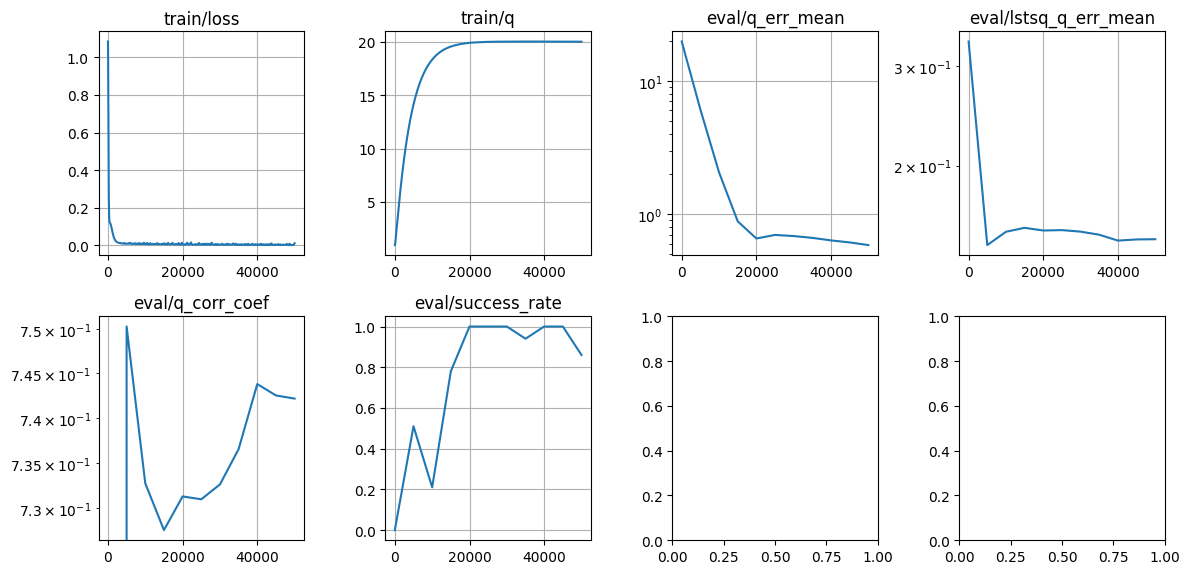

100%|██████████| 50000/50000 [09:28<00:00, 87.95it/s]


In [12]:
batch_size = 1024
tau = 0.005
num_taus = 32
num_tau_primes = 32
kappa = 1.0
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards = env.rewards
# v_min = rewards.min() / (1 - discount)
# v_max = rewards.max() / (1 - discount)

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, iq_critic_key = jax.random.split(key)

example_batch = sample_batch(2)
iq_critic = ImplicitQuantileCritic()
iq_critic_params = iq_critic.init(iq_critic_key, 
                                  example_batch['observations'], 
                                  example_batch['actions'], 
                                  example_batch['observations'][:, None].astype(jnp.float32))
target_iq_critic_params = copy.deepcopy(iq_critic_params)

def quantile_huber_loss(td_errors, taus, kappa):
  element_wise_huber_loss = jnp.where(
    jnp.abs(td_errors) <= kappa, 
    0.5 * td_errors ** 2,
    kappa * (jnp.abs(td_errors) - 0.5 * kappa)
  )
  
  # huber_loss = jnp.abs(
  #   taus[..., None] - (jax.lax.stop_gradient(td_errors) < 0).astype(jnp.float32)
  # ) * element_wise_huber_loss / kappa  # (batch_size, num_taus, num_tau_primes)
  huber_loss = jnp.abs(
    taus[..., None] - (td_errors < 0).astype(jnp.float32)
  ) * element_wise_huber_loss / kappa  # (batch_size, num_taus, num_tau_primes)
  
  huber_loss = huber_loss.sum(axis=1).mean()
  
  return huber_loss

def loss_fn(params, target_params, batch, rng):
  rng, tau_rng, next_tau_rng, tau_prime_rng = jax.random.split(rng, 4)
  
  taus = jax.random.uniform(tau_rng, shape=(batch_size, num_taus))
  quantiles = iq_critic.apply(params, batch['observations'], batch['actions'], taus)  # (batch_size, num_taus, 1)
  
  next_taus = jax.random.uniform(next_tau_rng, shape=(batch_size * env.nA, num_taus))
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  next_quantiles = iq_critic.apply(target_params, next_observations, next_actions, next_taus)
  next_quantiles = next_quantiles.reshape(batch_size, env.nA, num_taus)
  next_qs = next_quantiles.mean(axis=-1)
  next_actions = jnp.argmax(next_qs, axis=-1)
  
  # next_qs, next_probs = cate_critic.apply(target_params, next_observations, next_actions)
  # next_probs = next_probs.reshape([batch_size, env.nA, num_atoms])
  # next_qs = next_qs.reshape([batch_size, env.nA])
  # next_actions = jnp.argmax(next_qs, axis=-1)
  # next_probs = jnp.sum(next_probs * jax.nn.one_hot(next_actions, env.nA)[..., None], axis=1)
  
  tau_primes = jax.random.uniform(tau_prime_rng, shape=(batch_size, num_tau_primes))
  next_quantiles = iq_critic.apply(target_params, batch['next_observations'], next_actions, tau_primes)
  next_quantiles = next_quantiles.transpose([0, 2, 1])  # (batch_size, 1, num_tau_primes)
  target_quantiles = batch['rewards'][:, None, None] + discount * next_quantiles
  
  td_errors = target_quantiles - quantiles  # (batch_size, num_taus, num_tau_primes)
  
  loss = quantile_huber_loss(td_errors, taus, kappa)
  
  # for logging
  q = jnp.mean(quantiles.squeeze(-1), axis=1)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(iq_critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch, rng):
  (loss, info), grads = grad_fn(params, target_params, batch, rng)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params, rng):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)
  
  rng, tau_rng = jax.random.split(rng, 2)
  taus = jax.random.uniform(tau_rng, shape=(obs.shape[0], num_taus))
  quantiles = iq_critic.apply(params, obs, actions, taus)  # (nS * nA, num_taus, 1)
  q = jnp.mean(quantiles.squeeze(-1), axis=1)
  q = q.reshape([env.nS, env.nA])
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q.reshape(-1),
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q.reshape(-1))[0, 1]
  
  # evaluate the policy
  a = jnp.argmax(q, axis=-1)
  policy = jax.nn.one_hot(a, env.nA)
  policy = np.asarray(policy)
  
  # evaluation
  num_eval_episodes = 100
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=policy[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)
  
  info = {
    'q_err_mean': q_err_mean,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'q_corr_coef': q_corr_coef,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  key, train_key = jax.random.split(key)
  
  batch = sample_batch(batch_size)
  iq_critic_params, target_iq_critic_params, opt_state, loss, info = update_fn(
    iq_critic_params, target_iq_critic_params, opt_state, batch, train_key)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    key, eval_key = jax.random.split(key)
    eval_info = evaluate_fn(iq_critic_params, eval_key)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


#### Flow distributional Q-learning

In [35]:
class CriticVectorField(nn.Module):
  @nn.compact
  def __call__(self, ret, time, obs, action):
    obs = jax.nn.one_hot(obs, env.nS)
    action = jax.nn.one_hot(action, env.nA)
    inputs = jnp.concatenate([ret, time, obs, action], axis=-1)

    vector_field = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(1),
    ])(inputs)
    
    return vector_field

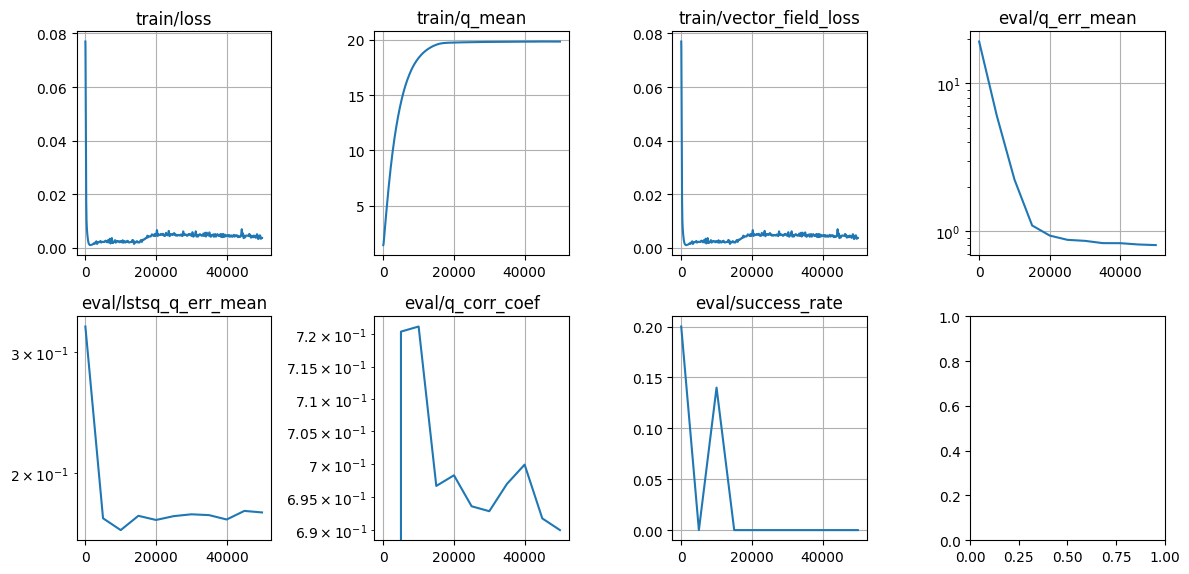

100%|██████████| 50000/50000 [01:51<00:00, 447.66it/s]


In [ ]:
batch_size = 1024
tau = 0.005
lam = 0.0
num_flow_steps = 10
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards = env.rewards
min_reward = rewards.min()
max_reward = rewards.max()

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_vf_key, target_critic_vf_key = jax.random.split(key, 3)

example_batch = sample_batch(2)
critic_vf = CriticVectorField()

ex_returns = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)
ex_times = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)

critic_vf_params = critic_vf.init(critic_vf_key, 
                                  ex_returns, ex_times, 
                                  example_batch['observations'], example_batch['actions'])
target_critic_vf_params = copy.deepcopy(critic_vf_params)

@jax.jit
def compute_flow_returns(
  params,
  noises,
  observations,
  actions,
  init_times=None,
  end_times=None,
):
  """Compute returns from the return flow model using the Euler method."""
  noisy_returns = noises
  if init_times is None:
    init_times = jnp.zeros((*noisy_returns.shape[:-1], 1), dtype=noisy_returns.dtype)
  if end_times is None:
    end_times = jnp.ones((*noisy_returns.shape[:-1], 1), dtype=noisy_returns.dtype)
  step_size = (end_times - init_times) / num_flow_steps

  def func(carry, i):
    """
    carry: (noisy_goals, )
    i: current step index
    """
    (noisy_returns, ) = carry

    times = i * step_size + init_times
    
    # euler method
    vector_field = critic_vf.apply(
      params, noisy_returns, times, observations, actions)
    new_noisy_returns = noisy_returns + step_size * vector_field
    
    # midpoint method
    # mid_vector_field = critic_vf.apply(
    #   params, noisy_returns, times, observations, actions)
    # mid_noisy_returns = noisy_returns + 0.5 * step_size * mid_vector_field
    # mid_times = times + 0.5 * step_size
    # vector_field = critic_vf.apply(
    #   params, mid_noisy_returns, mid_times, observations, actions)
    # new_noisy_returns = noisy_returns + step_size * vector_field
    
    new_noisy_returns = jnp.clip(
      new_noisy_returns,
      min_reward / (1.0 - discount),
      max_reward / (1.0 - discount),
    )

    return (new_noisy_returns, ), None

  # Use lax.scan to do the iteration
  (noisy_returns, ), _ = jax.lax.scan(
      func, (noisy_returns,), jnp.arange(num_flow_steps))
  # noisy_returns = jnp.clip(
  #   noisy_returns,
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )

  return noisy_returns

def loss_fn(params, target_params, batch, rng):
  rng, q_noise_rng, noise_rng, time_rng, q_rng = jax.random.split(rng, 5)
  
  # q_noises = jax.random.uniform(q_noise_rng, (batch_size * env.nA, 1),
  #                               minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  q_noises = jax.random.uniform(q_noise_rng, (batch_size * env.nA, 1))
  # q_noises = jax.random.normal(q_noise_rng, (batch_size * env.nA, 1))
  # q1 = (q_noises1 + critic_vf.apply(
  #   target_params, q_noises1, jnp.zeros((batch_size, 1)), 
  #   batch['observations'], jnp.zeros_like(batch['observations'])))
  # q2 = (q_noises2 + critic_vf.apply(
  #   target_params, q_noises2, jnp.zeros((batch_size, 1)), 
  #   batch['observations'], jnp.ones_like(batch['observations'])))
  # q = jnp.concatenate([q1, q2], axis=1)
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  # qs = compute_flow_returns(
  #   target_params, q_noises, next_observations, next_actions)
  qs = (q_noises + critic_vf.apply(
    target_params, q_noises, jnp.zeros_like(q_noises), next_observations, next_actions))
  qs = qs.reshape([batch_size, env.nA])
  next_actions = jnp.argmax(qs, axis=1)
  next_actions = jax.lax.stop_gradient(next_actions)
  # next_actions = batch['next_actions']
  
  times = jax.random.uniform(time_rng, (batch_size, 1))
  # noises = jax.random.uniform(noise_rng, (batch_size, 1),
  #                             minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  noises = jax.random.uniform(noise_rng, (batch_size, 1))
  # noises = jax.random.normal(noise_rng, (batch_size, 1))
  # next_returns = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], next_actions)
  # noises = jnp.sum(q_noises.reshape([batch_size, env.nA, 1]) * jax.nn.one_hot(next_actions, env.nA)[..., None], axis=1)
  next_returns = compute_flow_returns(
    target_params, noises, batch['next_observations'], next_actions)
  returns = jnp.expand_dims(batch['rewards'], axis=-1) + discount * next_returns
  # returns = jnp.clip(
  #   returns,
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )
  
  # rng, noise_rng = jax.random.split(rng)
  # noises = jax.random.uniform(noise_rng, (batch_size, 1),
  #                             minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  # noises = jax.random.normal(noise_rng, (batch_size, 1))
  noisy_returns = times * returns + (1.0 - times) * noises
  target_vector_field = returns - noises
  
  vector_field = critic_vf.apply(params, noisy_returns, times, batch['observations'], batch['actions'])
  vector_field_loss = jnp.mean((vector_field - target_vector_field) ** 2)
  
  # rng, noise_rng = jax.random.split(rng)
  # noises = jax.random.uniform(noise_rng, (batch_size, 1),
  #                             minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  # noisy_next_returns = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], next_actions, end_times=times)
  # transformed_noisy_returns = jnp.expand_dims(batch['rewards'], axis=-1) + discount * noisy_next_returns
  # # transformed_noisy_returns = jnp.clip(
  # #   transformed_noisy_returns,
  # #   min_reward / (1.0 - discount),
  # #   max_reward / (1.0 - discount),
  # # )

  # vector_field = critic_vf.apply(
  #   params, transformed_noisy_returns, times, batch['observations'], batch['actions'])
  # next_vector_field = critic_vf.apply(
  #   params, noisy_next_returns, times, batch['next_observations'], next_actions)
  # target_vector_field = critic_vf.apply(
  #   target_params, transformed_noisy_returns, times, batch['observations'], batch['actions'])
  # target_next_vector_field = critic_vf.apply(
  #   target_params, noisy_next_returns, times, batch['next_observations'], next_actions)
  # bootstrapped_vector_field_loss = jnp.mean((vector_field - target_next_vector_field) ** 2 +
  #                                           (next_vector_field - target_vector_field) ** 2)
  
  # loss = vector_field_loss + lam * bootstrapped_vector_field_loss
  loss = vector_field_loss
  
  # Additional metrics for logging.
  # q_noises = jax.random.uniform(q_rng, (batch_size, 1),
  #                               minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  q_noises = jax.random.uniform(q_rng, (batch_size, 1))
  # q_noises = jax.random.normal(q_rng, (batch_size, 1))
  # q = compute_flow_returns(
  #   params, q_noises, batch['observations'], batch['actions'])
  q = (q_noises + critic_vf.apply(
    params, q_noises, jnp.zeros((batch_size, 1)), 
    batch['observations'], batch['actions']))

  info = {
    'loss': loss,
    'vector_field_loss': vector_field_loss,
    # 'bootstrapped_vector_field_loss': bootstrapped_vector_field_loss,
    'q_mean': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=5e-4 * 512 * 2)
optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_vf_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch, rng):
  (loss, info), grads = grad_fn(params, target_params, batch, rng)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params, rng):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)

  # qs = []
  # for _ in range(16):
  #   # q_noises = jax.random.uniform(q_rng, (obs.shape[0], 1),
  #   #                               minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  #   rng, q_rng = jax.random.split(rng)
  #   # q_noises = jax.random.normal(q_rng, (obs.shape[0], 1))
  #   q_noises = jax.random.uniform(q_rng, (obs.shape[0], 1))
  #   # q = compute_flow_returns(
  #   #   params, q_noises, obs, actions)
  #   q = (q_noises + critic_vf.apply(
  #     params, q_noises, jnp.zeros((obs.shape[0], 1)), 
  #     obs, actions))

  rng, q_rng = jax.random.split(rng)
  # q_noises = jax.random.normal(q_rng, (obs.shape[0], 1))
  q_noises = jax.random.uniform(q_rng, (obs.shape[0], 1))
  # q = compute_flow_returns(
  #   params, q_noises, obs, actions)
  q = (q_noises + critic_vf.apply(params, q_noises, jnp.zeros((obs.shape[0], 1)), obs, actions))
  q = q.reshape(env.nS, env.nA)
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q.reshape(-1),
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q.reshape(-1))[0, 1]
  
  # evaluate the policy
  a = jnp.argmax(q, axis=-1)
  policy = jax.nn.one_hot(a, env.nA)
  policy = np.asarray(policy)
  
  # evaluation
  num_eval_episodes = 100
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=policy[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)
  
  info = {
    'q_err_mean': q_err_mean,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'q_corr_coef': q_corr_coef,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  key, train_key = jax.random.split(key)
  batch = sample_batch(batch_size)
  
  critic_vf_params, target_critic_vf_params, opt_state, loss, info = update_fn(
    critic_vf_params, target_critic_vf_params, opt_state, batch, train_key)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    key, eval_key = jax.random.split(key)
    eval_info = evaluate_fn(critic_vf_params, eval_key)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
# lam = 0.01
fdql_metrics = metrics
print(fdql_metrics['eval/q_err_mean'][-1])
print(fdql_metrics['eval/lstsq_q_err_mean'][-1])
print(fdql_metrics['eval/q_corr_coef'][-1])
print(fdql_metrics['eval/success_rate'][-1])

[5.000000e+04 3.481794e-01]
[5.00000000e+04 3.22284341e-01]
[5.0000000e+04 1.7727001e-01]


IndexError: list index out of range

#### Flow distributional Q-learning (IQN style)

In [35]:
class CosineEmbedding(nn.Module):
  num_cosines: int = 64
  embedding_dim: int = 512
  
  @nn.compact
  def __call__(self, returns):
    batch_size, num_rand_samples = returns.shape[0:2]

    freqs = jnp.pi * jnp.arange(1, self.num_cosines + 1)[None, None]
    cos_embeddings = jnp.cos(freqs * returns).reshape(
        batch_size * num_rand_samples, self.num_cosines)
    return_embeddings = nn.Sequential([
        nn.Dense(self.embedding_dim),
        nn.gelu,
    ])(cos_embeddings)
    
    return_embeddings = return_embeddings.reshape(batch_size, num_rand_samples, self.embedding_dim)
    
    return return_embeddings

class CriticVectorField(nn.Module):
  cos_embed: CosineEmbedding = CosineEmbedding()
  embedding_dim: int = 512
  
  @nn.compact
  def __call__(self, returns, times, obs, actions):
    return_embeddings = self.cos_embed(returns)  # (batch_size, num_rand_samples, embedding_dims)
    
    obs = jax.nn.one_hot(obs, env.nS)
    actions = jax.nn.one_hot(actions, env.nA)
    inputs = jnp.concatenate([obs, actions, times], axis=-1)

    sat_embeddings = nn.Sequential([
      nn.Dense(self.embedding_dim),
      nn.gelu,
    ])(inputs)
    
    embeddings = (sat_embeddings[:, None] * return_embeddings)  # (batch_size, num_rand_samples, embedding_dims)
    vector_field = nn.Sequential([
      nn.Dense(self.embedding_dim),
      nn.gelu,
      nn.Dense(1)
    ])(embeddings)  # (batch_size, num_rand_samples, 1)

    return vector_field

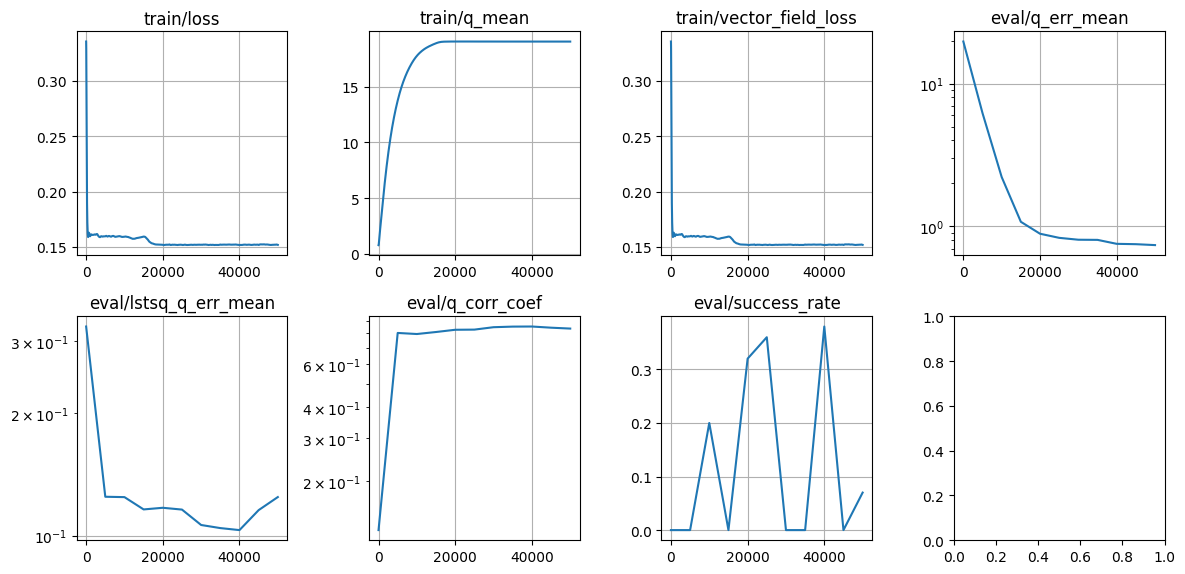

100%|██████████| 50000/50000 [10:00<00:00, 83.23it/s]


In [ ]:
batch_size = 1024
tau = 0.005
lam = 0.0
num_rand_samples = 16
num_flow_steps = 10
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards = env.rewards
min_reward = rewards.min()
max_reward = rewards.max()

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_vf_key, target_critic_vf_key = jax.random.split(key, 3)

example_batch = sample_batch(2)
critic_vf = CriticVectorField()

ex_returns = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)
ex_times = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)

critic_vf_params = critic_vf.init(critic_vf_key, 
                                  ex_returns, ex_times, 
                                  example_batch['observations'], example_batch['actions'])
target_critic_vf_params = copy.deepcopy(critic_vf_params)

@jax.jit
def compute_flow_returns(
  params,
  noises,
  observations,
  actions,
  init_times=None,
  end_times=None,
):
  """Compute returns from the return flow model using the Euler method."""
  noisy_returns = noises
  if init_times is None:
    init_times = jnp.zeros((*noisy_returns.shape[:-2], 1), dtype=noisy_returns.dtype)
  if end_times is None:
    end_times = jnp.ones((*noisy_returns.shape[:-2], 1), dtype=noisy_returns.dtype)
  step_size = (end_times - init_times) / num_flow_steps

  def func(carry, i):
    """
    carry: (noisy_goals, )
    i: current step index
    """
    (noisy_returns, ) = carry

    times = i * step_size + init_times
    
    # euler method
    vector_field = critic_vf.apply(
      params, noisy_returns, times, observations, actions)
    new_noisy_returns = noisy_returns + step_size[:, None] * vector_field

    
    # midpoint method
    # mid_vector_field = critic_vf.apply(
    #   params, noisy_returns, times, observations, actions)
    # mid_noisy_returns = noisy_returns + 0.5 * step_size * mid_vector_field
    # mid_times = times + 0.5 * step_size
    # vector_field = critic_vf.apply(
    #   params, mid_noisy_returns, mid_times, observations, actions)
    # new_noisy_returns = noisy_returns + step_size * vector_field
    
    new_noisy_returns = jnp.clip(
      new_noisy_returns,
      min_reward / (1.0 - discount),
      max_reward / (1.0 - discount),
    )

    return (new_noisy_returns, ), None

  # Use lax.scan to do the iteration
  (noisy_returns, ), _ = jax.lax.scan(
      func, (noisy_returns,), jnp.arange(num_flow_steps))
  # noisy_returns = jnp.clip(
  #   noisy_returns,
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )

  return noisy_returns

def loss_fn(params, target_params, batch, rng):
  rng, q_noise_rng, noise_rng, time_rng, q_rng = jax.random.split(rng, 5)
  
  # q_noises = jax.random.uniform(q_noise_rng, (batch_size * env.nA, 1),
  #                               minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  q_noises = jax.random.uniform(q_noise_rng, (batch_size * env.nA, num_rand_samples, 1))
  # q_noises = jax.random.normal(q_noise_rng, (batch_size * env.nA, 1))
  # q1 = (q_noises1 + critic_vf.apply(
  #   target_params, q_noises1, jnp.zeros((batch_size, 1)), 
  #   batch['observations'], jnp.zeros_like(batch['observations'])))
  # q2 = (q_noises2 + critic_vf.apply(
  #   target_params, q_noises2, jnp.zeros((batch_size, 1)), 
  #   batch['observations'], jnp.ones_like(batch['observations'])))
  # q = jnp.concatenate([q1, q2], axis=1)
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  # qs = compute_flow_returns(
  #   target_params, q_noises, next_observations, next_actions)
  qs = critic_vf.apply(
    target_params, q_noises, jnp.zeros((batch_size * env.nA, 1)), next_observations, next_actions)  # (batch_size * env.nA, num_rand_samples, 1)
  qs = qs.reshape([batch_size, env.nA, num_rand_samples])
  qs = jnp.mean(qs, axis=-1)
  next_actions = jnp.argmax(qs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  times = jax.random.uniform(time_rng, (batch_size, 1))
  # noises = jax.random.uniform(noise_rng, (batch_size, 1),
  #                             minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  noises = jax.random.uniform(noise_rng, (batch_size, num_rand_samples, 1))
  # noises = jax.random.normal(noise_rng, (batch_size, 1))
  # next_returns = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], next_actions)
  # noises = jnp.sum(q_noises.reshape([batch_size, env.nA, 1]) * jax.nn.one_hot(next_actions, env.nA)[..., None], axis=1)
  next_returns = compute_flow_returns(
    target_params, noises, batch['next_observations'], next_actions)  # (batch_size, num_rand_samples, 1)
  returns = batch['rewards'][:, None, None] + discount * next_returns
  # returns = returns.transpose([0, 2, 1])  # (batch_size, 1, num_rand_samples)
  # returns = jnp.clip(
  #   returns,
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )
  
  rng, noise_rng = jax.random.split(rng)
  noises = jax.random.uniform(noise_rng, (batch_size, num_rand_samples, 1))
  # noises = jax.random.normal(noise_rng, (batch_size, 1))
  noisy_returns = times[:, None] * returns + (1.0 - times[:, None]) * noises
  target_vector_field = returns - noises
  
  vector_field = critic_vf.apply(params, noisy_returns, times, batch['observations'], batch['actions'])
  vector_field_loss = jnp.mean((vector_field - target_vector_field) ** 2)
  
  # rng, noise_rng = jax.random.split(rng)
  # noises = jax.random.uniform(noise_rng, (batch_size, num_rand_samples, 1))
  # noisy_next_returns = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], next_actions, end_times=times)  # (batch_size, num_rand_samples, 1)
  # transformed_noisy_returns = batch['rewards'][:, None, None] + discount * noisy_next_returns
  # # transformed_noisy_returns = jnp.clip(
  # #   transformed_noisy_returns,
  # #   min_reward / (1.0 - discount),
  # #   max_reward / (1.0 - discount),
  # # )

  # # transformed_noisy_returns = jnp.roll(transformed_noisy_returns, 1, axis=0)
  # vector_field = critic_vf.apply(
  #   params, transformed_noisy_returns, times, batch['observations'], batch['actions'])
  # target_next_vector_field = critic_vf.apply(
  #   target_params, noisy_next_returns, times, batch['next_observations'], next_actions)
  # bootstrapped_vector_field_loss = jnp.mean((vector_field - target_next_vector_field) ** 2)
  
  # loss = vector_field_loss + lam * bootstrapped_vector_field_loss
  loss = vector_field_loss
  # loss = bootstrapped_vector_field_loss
  
  # Additional metrics for logging.
  # q_noises = jax.random.uniform(q_rng, (batch_size, 1),
  #                               minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  q_noises = jax.random.uniform(q_rng, (batch_size, num_rand_samples, 1))
  # q_noises = jax.random.normal(q_rng, (batch_size, 1))
  # q = compute_flow_returns(
  #   params, q_noises, batch['observations'], batch['actions'])
  q = critic_vf.apply(
    params, q_noises, jnp.zeros((batch_size, 1)), 
    batch['observations'], batch['actions'])  # (batch_size, num_rand_samples, 1)
  q = jnp.mean(q.squeeze(-1), axis=1)

  info = {
    'loss': loss,
    'vector_field_loss': vector_field_loss,
    # 'bootstrapped_vector_field_loss': bootstrapped_vector_field_loss,
    'q_mean': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_vf_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch, rng):
  (loss, info), grads = grad_fn(params, target_params, batch, rng)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params, rng):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)

  rng, q_rng = jax.random.split(rng)
  # q_noises = jax.random.normal(q_rng, (obs.shape[0], 1))
  q_noises = jax.random.uniform(q_rng, (obs.shape[0], num_rand_samples, 1))
  # q = compute_flow_returns(
  #   params, q_noises, obs, actions)
  q = critic_vf.apply(params, q_noises, jnp.zeros((obs.shape[0], 1)), obs, actions)  # (batch_size, num_samples, 1)
  q = jnp.mean(jnp.squeeze(q), axis=-1)
  q = q.reshape(env.nS, env.nA)
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q.reshape(-1),
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q.reshape(-1))[0, 1]
  
  # evaluate the policy
  a = jnp.argmax(q, axis=-1)
  policy = jax.nn.one_hot(a, env.nA)
  policy = np.asarray(policy)
  
  # evaluation
  num_eval_episodes = 100
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=policy[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)
  
  info = {
    'q_err_mean': q_err_mean,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'q_corr_coef': q_corr_coef,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  key, train_key = jax.random.split(key)
  batch = sample_batch(batch_size)
  
  critic_vf_params, target_critic_vf_params, opt_state, loss, info = update_fn(
    critic_vf_params, target_critic_vf_params, opt_state, batch, train_key)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    key, eval_key = jax.random.split(key)
    eval_info = evaluate_fn(critic_vf_params, eval_key)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


### Plots

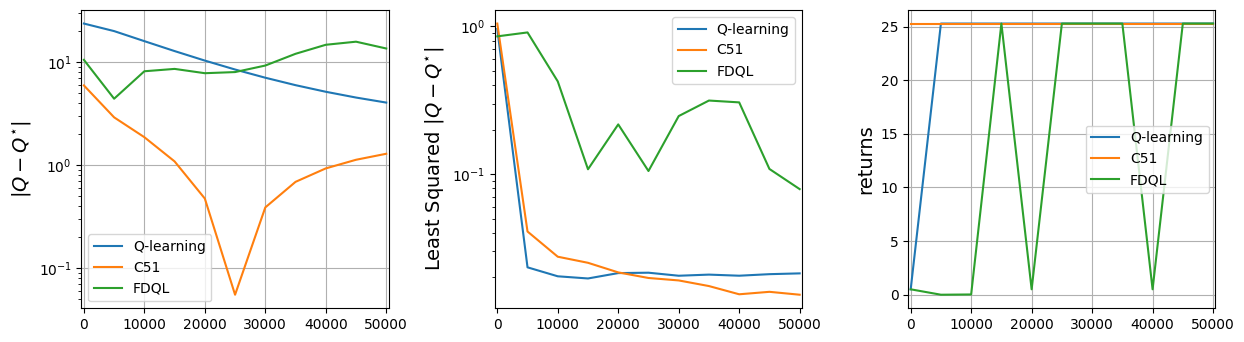

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.2))

metric_name = 'eval/q_err_mean'
ax = axes[0]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'$| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()
ax.grid(zorder=3)     

metric_name = 'eval/lstsq_q_err_mean'
ax = axes[1]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'Least Squared $| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()

metric_name = 'eval/returns'
ax = axes[2]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'returns', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.legend()

# ax.set_ylim([-5, 120 + 5])
# ax.set_yticks([0, 120])
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.grid(zorder=3)     

fig.tight_layout(rect=(-0.026, -0.06, 1.02, 1.04))  # rect = (left, bottom, right, top), default: (0, 0, 1, 1)
# filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/convergence_speed_ablation_lc.pdf"
# fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
